In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
print("PROJECT_ROOT:", PROJECT_ROOT)

if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

plt.style.use("seaborn-v0_8")
sns.set_theme()

results_path = os.path.join(PROJECT_ROOT, "experiments", "final_model_summary.csv")
print("Loading:", results_path)

if not os.path.exists(results_path):
    raise FileNotFoundError(f"final_model_summary.csv not found at: {results_path}")

summary_df = pd.read_csv(results_path)
print("Summary shape:", summary_df.shape)

display(summary_df)


PROJECT_ROOT: /home/linux/PyCharmMiscProject/projects/adaptive-cost-sensitive-loss
Loading: /home/linux/PyCharmMiscProject/projects/adaptive-cost-sensitive-loss/experiments/final_model_summary.csv
Summary shape: (2, 12)


,model,accuracy,precision,recall,f1,roc_auc,pr_auc,tn,fp,fn,tp,total_cost
0,MLP (Adaptive Cost-Sensitive Loss),0.999034,0.669291,0.867347,0.755556,0.978423,0.813973,56822,42,13,85,172.0
1,RandomForest (baseline),0.999614,0.941860,0.826531,0.880435,0.962346,0.873043,56859,5,17,81,175.0


In [5]:
import numpy as np

# Sort models by total cost (lower is better)
summary_sorted = summary_df.sort_values("total_cost").reset_index(drop=True)

# Set model order (used in all plots)
model_order = summary_sorted["model"].tolist()

# Global plot style
plt.rcParams.update({
    "figure.figsize": (8, 4.5),
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.titleweight": "bold",
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

summary_sorted


,model,accuracy,precision,recall,f1,roc_auc,pr_auc,tn,fp,fn,tp,total_cost
0,MLP (Adaptive Cost-Sensitive Loss),0.999034,0.669291,0.867347,0.755556,0.978423,0.813973,56822,42,13,85,172.0
1,RandomForest (baseline),0.999614,0.941860,0.826531,0.880435,0.962346,0.873043,56859,5,17,81,175.0


In [4]:
best_row = summary_sorted.iloc[0]

print("Best model by total cost:")
print(f"Model      : {best_row['model']}")
print(f"Total cost : {best_row['total_cost']}")
print(f"FN, FP     : {best_row['fn']} (FN), {best_row['fp']} (FP)")
print(f"Recall     : {best_row['recall']:.4f}")
print(f"Precision  : {best_row['precision']:.4f}")
print(f"PR-AUC     : {best_row['pr_auc']:.4f}")


Best model by total cost:
Model      : MLP (Adaptive Cost-Sensitive Loss)
Total cost : 172.0
FN, FP     : 13 (FN), 42 (FP)
Recall     : 0.8673
Precision  : 0.6693
PR-AUC     : 0.8140


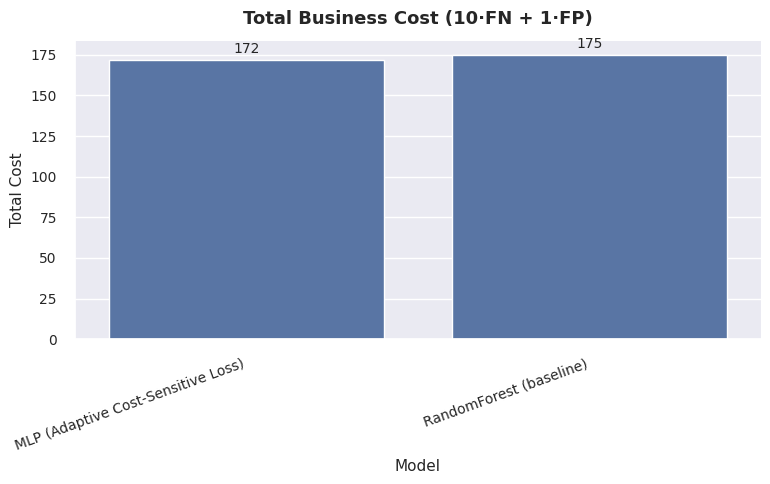

In [6]:
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=summary_sorted,
    x="model",
    y="total_cost",
    order=model_order,
)

ax.set_title("Total Business Cost (10·FN + 1·FP)", pad=12)
ax.set_xlabel("Model")
ax.set_ylabel("Total Cost")

plt.xticks(rotation=20, ha="right")

# Add value labels on bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.0f}",
        (p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()


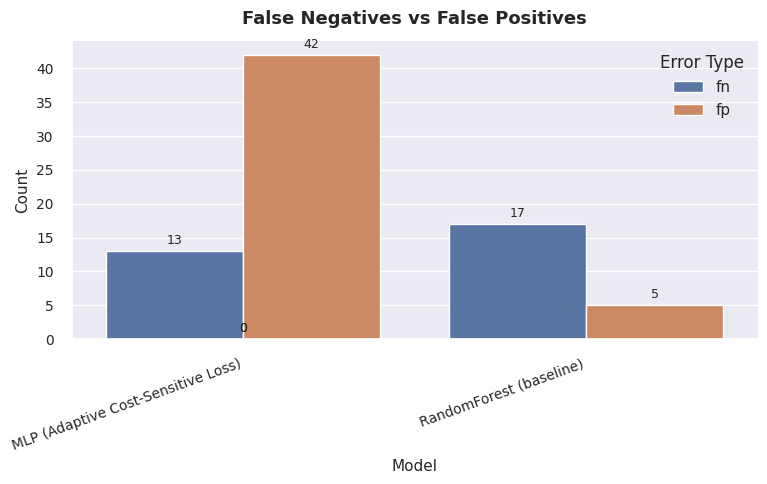

In [7]:
err_df = summary_sorted[["model", "fn", "fp"]].copy()

melted = err_df.melt(
    id_vars="model",
    value_vars=["fn", "fp"],
    var_name="error_type",
    value_name="count",
)

plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=melted,
    x="model",
    y="count",
    hue="error_type",
    order=model_order,
)

ax.set_title("False Negatives vs False Positives", pad=12)
ax.set_xlabel("Model")
ax.set_ylabel("Count")
plt.xticks(rotation=20, ha="right")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{int(height)}",
        (p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="bottom",
        fontsize=9,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.legend(title="Error Type")
plt.tight_layout()
plt.show()


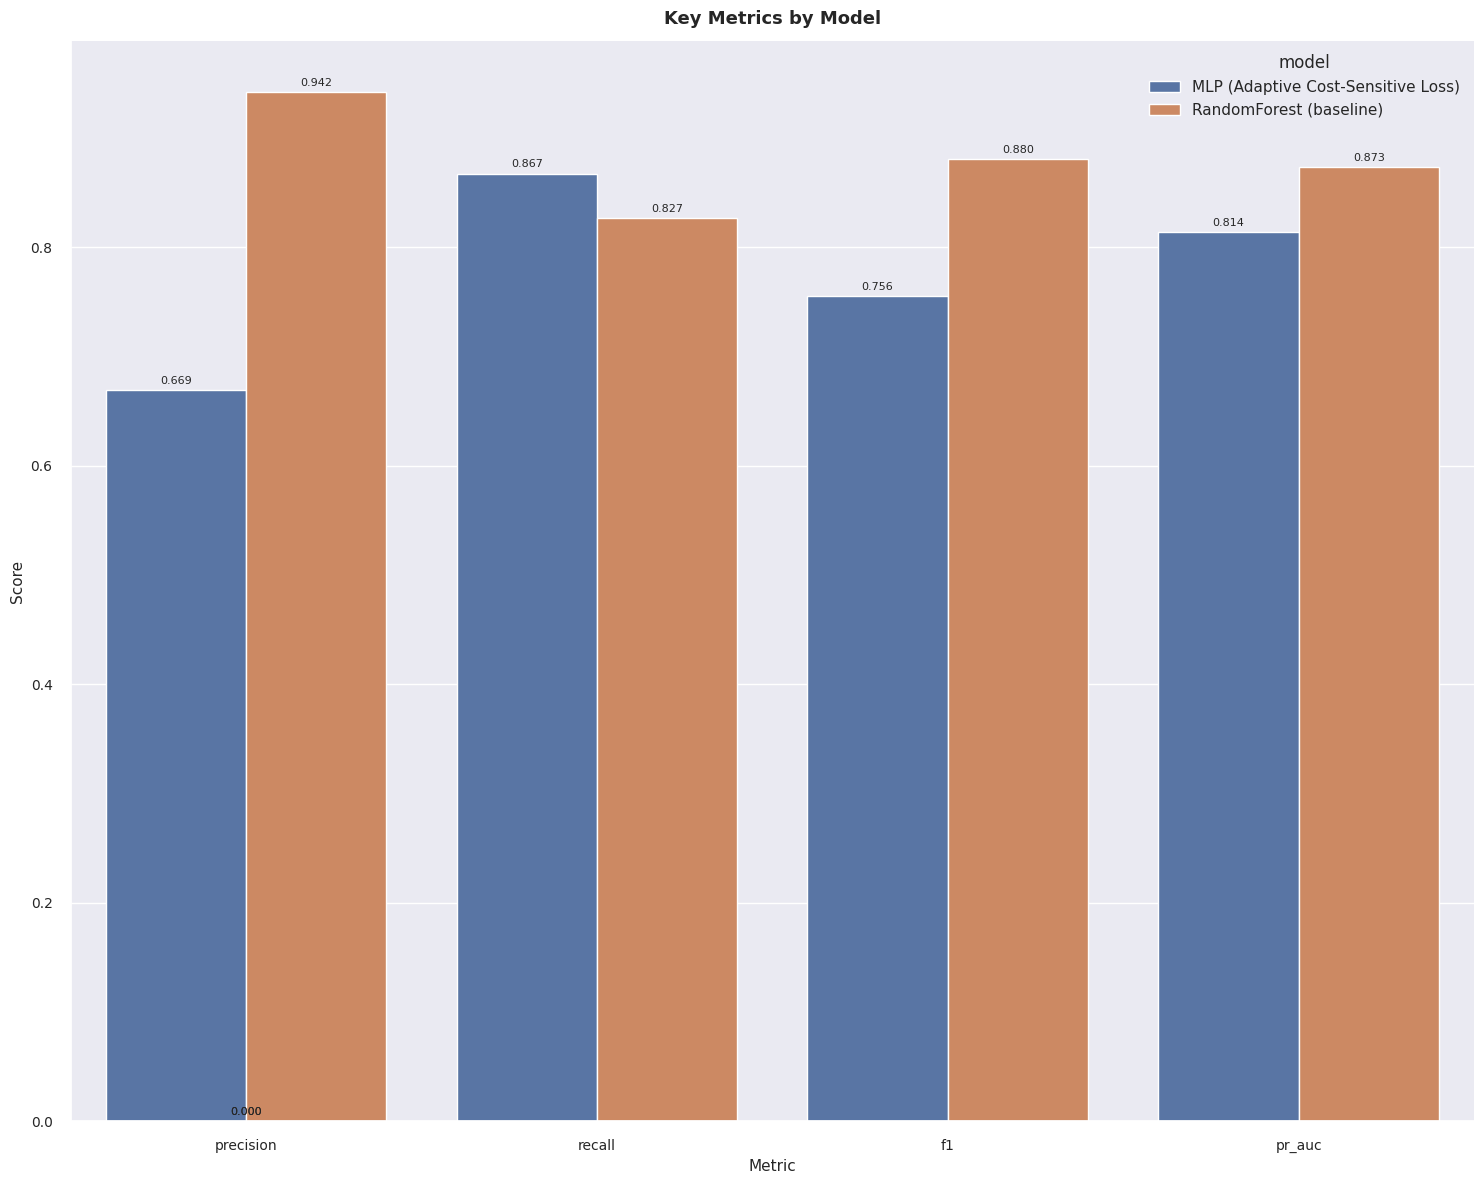

In [15]:
metrics_to_plot = ["precision", "recall", "f1", "pr_auc"]

metric_df = summary_sorted[["model"] + metrics_to_plot].copy()
metric_long = metric_df.melt(
    id_vars="model",
    value_vars=metrics_to_plot,
    var_name="metric",
    value_name="value",
)

plt.figure(figsize=(15, 12))
ax = sns.barplot(
    data=metric_long,
    x="metric",
    y="value",
    hue="model",
)

ax.set_title("Key Metrics by Model", pad=12)
ax.set_xlabel("Metric")
ax.set_ylabel("Score")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height:.3f}",
        (p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="bottom",
        fontsize=8,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()


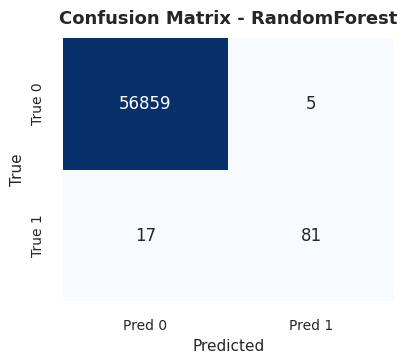

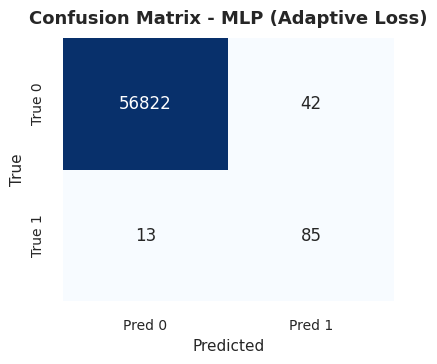

In [16]:
def plot_confusion_from_row(row, title_suffix=""):
    cm = np.array([
        [row["tn"], row["fp"]],
        [row["fn"], row["tp"]],
    ], dtype=int)

    plt.figure(figsize=(4.2, 3.8))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        xticklabels=["Pred 0", "Pred 1"],
        yticklabels=["True 0", "True 1"],
    )
    plt.title(f"Confusion Matrix - {title_suffix}", pad=10)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


rf_row = summary_sorted[summary_sorted["model"].str.contains("RandomForest", case=False)].iloc[0]
adapt_row = summary_sorted[summary_sorted["model"].str.contains("Adaptive", case=False)].iloc[0]

plot_confusion_from_row(rf_row, "RandomForest")
plot_confusion_from_row(adapt_row, "MLP (Adaptive Loss)")


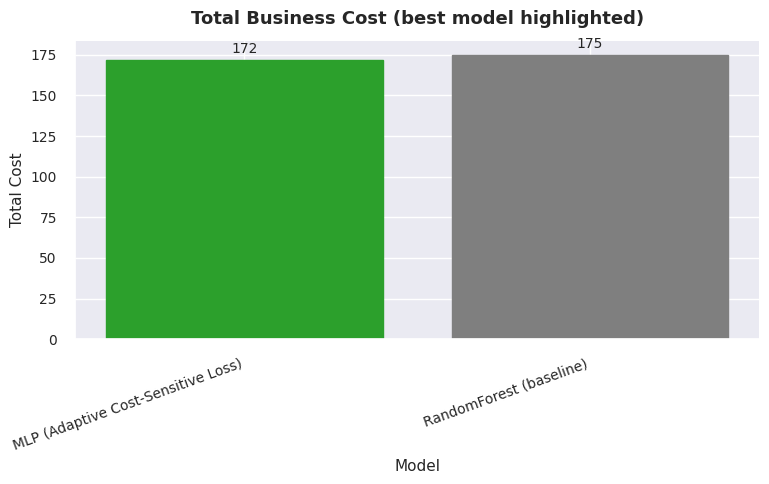

In [17]:
plt.figure(figsize=(8, 5))

best_cost = summary_sorted["total_cost"].min()

colors = ["tab:green" if c == best_cost else "tab:gray"
          for c in summary_sorted["total_cost"]]

ax = plt.bar(summary_sorted["model"], summary_sorted["total_cost"])

for bar, col in zip(ax, colors):
    bar.set_color(col)

plt.title("Total Business Cost (best model highlighted)", pad=12)
plt.xlabel("Model")
plt.ylabel("Total Cost")
plt.xticks(rotation=20, ha="right")

for p in ax:
    height = p.get_height()
    plt.annotate(
        f"{height:.0f}",
        (p.get_x() + p.get_width() / 2., height),
        ha="center",
        va="bottom",
        fontsize=10,
        xytext=(0, 3),
        textcoords="offset points"
    )

plt.tight_layout()
plt.show()
